In [2]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.loader import NeighborLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import MessagePassing, SAGEConv
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset

In [3]:
target_dataset = 'ogbn-arxiv'
# This will download the ogbn-arxiv to the 'networks' folder
dataset = PygNodePropPredDataset(name=target_dataset, root='networks')


In [4]:
data = dataset[0]
print(data)

Data(num_nodes=169343, edge_index=[2, 1166243], x=[169343, 128], node_year=[169343, 1], y=[169343, 1])


In [5]:
split_idx = dataset.get_idx_split() 
        
train_idx = split_idx['train']
valid_idx = split_idx['valid']
test_idx = split_idx['test']

In [6]:
train_loader = NeighborLoader(data, input_nodes=train_idx,
                              shuffle=True, num_workers=os.cpu_count() - 2,
                              batch_size=1024, num_neighbors=[30] * 2)
total_loader = NeighborLoader(data, input_nodes=None, num_neighbors=[-1],
                               batch_size=4096, shuffle=False,
                               num_workers=os.cpu_count() - 2)

/home/pouspo/Desktop/tensor/venv/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:60: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [7]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels,
                 hidden_channels, out_channels,
                 n_layers=2):
        
        super(SAGE, self).__init__()
        self.n_layers = n_layers
        self.layers = torch.nn.ModuleList()
        self.layers_bn = torch.nn.ModuleList()
        if n_layers == 1:
            self.layers.append(SAGEConv(in_channels, out_channels,   normalize=False))
        elif n_layers == 2:
            self.layers.append(SAGEConv(in_channels, hidden_channels, normalize=False))
            self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))
            self.layers.append(SAGEConv(hidden_channels, out_channels, normalize=False))
        else:
            self.layers.append(SAGEConv(in_channels, hidden_channels, normalize=False))
            self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(n_layers - 2):
            self.layers.append(SAGEConv(hidden_channels,  hidden_channels, normalize=False))
            self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))
                
            self.layers.append(SAGEConv(hidden_channels, out_channels, normalize=False))
                
        for layer in self.layers:
            layer.reset_parameters()
    def forward(self, x, edge_index):
        if len(self.layers) > 1:
            looper = self.layers[:-1]
        else:
            looper = self.layers
        
        for i, layer in enumerate(looper):
            x = layer(x, edge_index)
            try:
                x = self.layers_bn[i](x)
            except Exception as e:
                abs(1)
            finally:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        
        if len(self.layers) > 1:
            x = self.layers[-1](x, edge_index)
        return F.log_softmax(x, dim=-1), torch.var(x)
    
    def inference(self, total_loader, device):
        xs = []
        var_ = []
        for batch in total_loader:
            out, var = self.forward(batch.x.to(device), batch.edge_index.to(device))
            out = out[:batch.batch_size]
            xs.append(out.cpu())
            var_.append(var.item())
        
        out_all = torch.cat(xs, dim=0)
        
        return out_all, var_

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(data.x.shape[1], 256, dataset.num_classes, n_layers=2)
model.to(device)
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=7)

In [9]:
def test(model, device):
    evaluator = Evaluator(name=target_dataset)
    model.eval()
    out, var = model.inference(total_loader, device)
    y_true = data.y.cpu()
    y_pred = out.argmax(dim=-1, keepdim=True)
    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    val_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']
    return train_acc, val_acc, test_acc, torch.mean(torch.Tensor(var))

In [12]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"


In [13]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Processing...
Done!


In [14]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

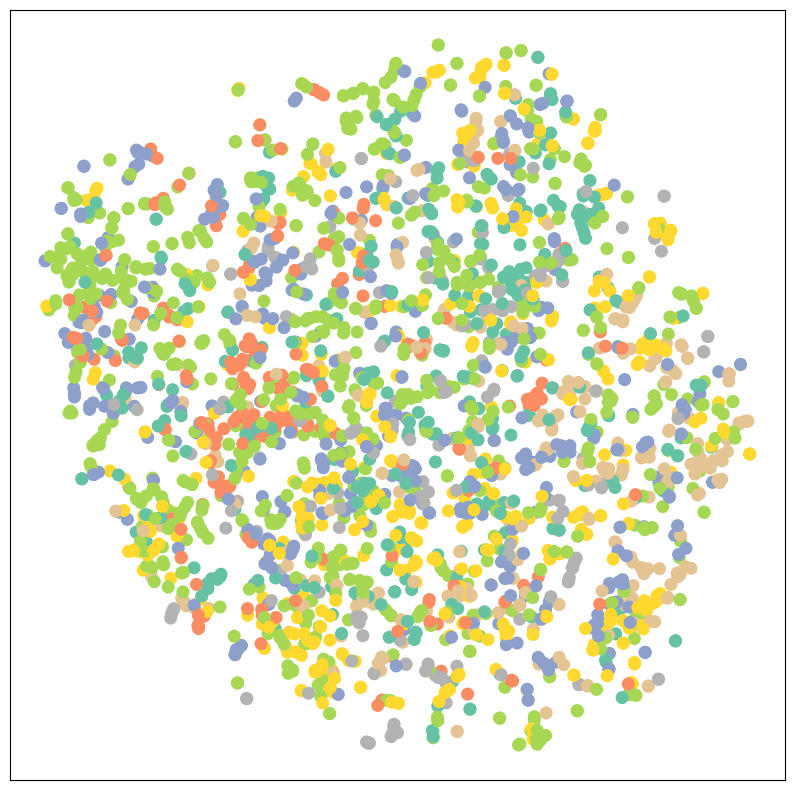

In [16]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [17]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


In [18]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.8150


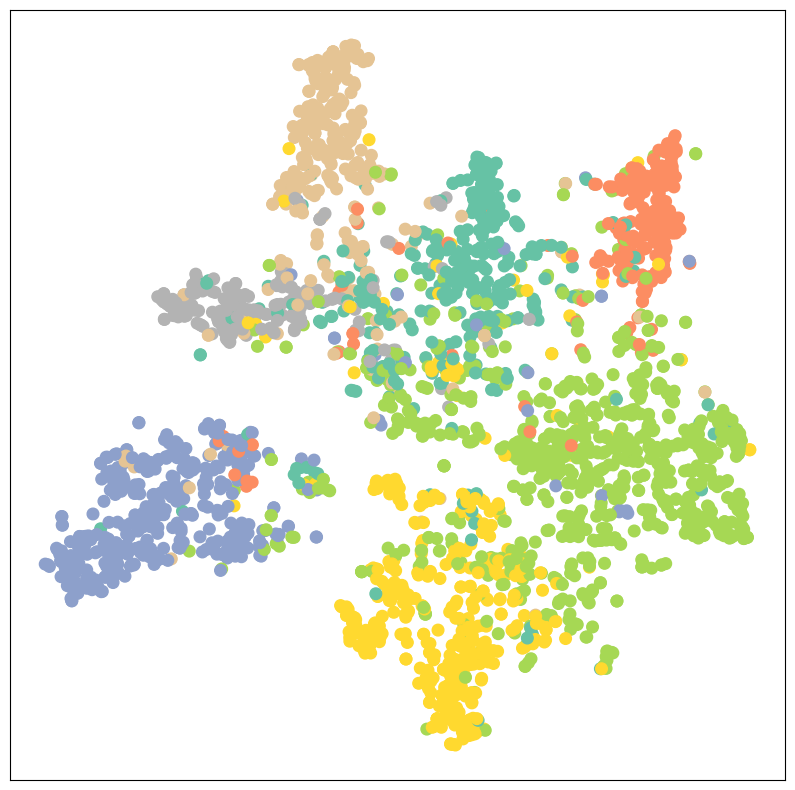

In [19]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)